# 須恵器（身）クラスタ解析モデル・色情報なし・クラスタ数6


## 前提情報

以下のファイルが下記パスにあること

1. ラベル情報ファイル (2022/2/22 時点)
    * ./20220222_sueki_label.csv
2. 須恵器データファイル(メッシュ補正済：voxelファイル) (2023/02/23 時点，色情報を使用しない)
    *  ./data/voxel/



In [2]:
!unzip -q ./sueki_data/20230223-128_sueki_dataset.zip

# パッケージインストール


In [ ]:
# tensorflow 2.9.2
!pip install -q --upgrade tensorflow==2.9.2 tensorflow-gpu==2.9.2
!pip install -q japanize_matplotlib
!pip install -q tensorflow-determinism classification-models-3D

# 仮ラベル付きのクラスタリング

In [4]:
import os
from glob import glob
import re
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random
import gc

from skimage.transform import resize
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
from matplotlib import cm
from keras.utils import np_utils

In [5]:

def set_seed(seed=200):
    tf.random.set_seed(seed)

    # optional
    # for numpy.random
    np.random.seed(seed)
    # for built-in random
    random.seed(seed)
    # for hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    

set_seed(54321)


## 定数定義

In [6]:
NUM_CLASSES = 6
NUM_CLUSTERS = 6
NUM_PCA_COMPONENTS = 6
BUFFER_SIZE = 1000
BATCH_SIZE = 8
EPOCHS = 60
CLUSTERING_INTERVAL = 3
DATA_DIR = '/content/data/voxel'
MI_FUTA = 'mi'
IMAGE_SIZE = 128
NUM_CHANNELS = 1

FEATURE_EXTRACTOR_MODEL_PATH = "feature_extractor_20230223-128-selu-noise-alpha-random2-IV3_{}_cls{}_ep{}.hdf5".format(MI_FUTA,NUM_CLUSTERS,EPOCHS)
CLASSIFIER_MODEL_PATH = "classifier_20230223-128-selu-noise-alpha-random2-IV3_{}_cls{}_ep{}.hdf5".format(MI_FUTA,NUM_CLUSTERS,EPOCHS)
DATASET_SAVE_PATH = "pseudo_dataset_20230223-128-selu-noise-alpha-random2-IV3_{}_cls{}_ep{}".format(MI_FUTA,NUM_CLUSTERS,EPOCHS)

DATASAVE_DIR = "{}_20230223-128-selu-noise-alpha-random2-IV3_deg30_cls{}_ep{}".format(MI_FUTA,NUM_CLUSTERS,EPOCHS)


## モデル定義

In [7]:
class ConvNet3D(keras.Model):
    def __init__(self):
        super(ConvNet3D, self).__init__()
        self.conv3d_1 = keras.layers.Conv3D(filters=64, kernel_initializer='lecun_normal', padding='same', kernel_size=3, activation='linear', name='conv3d_1')
        self.bn_1 = keras.layers.BatchNormalization()
        self.act_1 = keras.layers.Activation('selu')
        self.maxpool3d_1 = keras.layers.MaxPool3D(pool_size=2)
        
        
        self.conv3d_2 = keras.layers.Conv3D(filters=64, kernel_initializer='lecun_normal', padding='same', kernel_size=3, activation='linear', name='conv3d_2')
        self.bn_2 = keras.layers.BatchNormalization()
        self.act_2 = keras.layers.Activation('selu')
        self.maxpool3d_2 = keras.layers.MaxPool3D(pool_size=2)
        
        
        self.conv3d_3 = keras.layers.Conv3D(filters=128, kernel_initializer='lecun_normal', padding='same', kernel_size=3, activation='linear', name='conv3d_3')
        self.bn_3 = keras.layers.BatchNormalization()
        self.act_3 = keras.layers.Activation('selu')
        self.maxpool3d_3 = keras.layers.MaxPool3D(pool_size=2)
        
        
        self.conv3d_4 = keras.layers.Conv3D(filters=256, kernel_initializer='lecun_normal', padding='same', kernel_size=3, activation='linear', name='conv3d_4')
        self.bn_4 = keras.layers.BatchNormalization()
        self.act_4 = keras.layers.Activation('selu')
        self.maxpool3d_4 = keras.layers.MaxPool3D(pool_size=1)
        

        self.gap_1 = keras.layers.GlobalAveragePooling3D()
        
        self.dense_1 = keras.layers.Dense(128, kernel_initializer='lecun_normal')

    def call(self, inputs):
        x = self.conv3d_1(inputs)
        x = self.bn_1(x)
        x = self.act_1(x)
        x = self.maxpool3d_1(x)
        
        x = self.conv3d_2(x)
        x = self.bn_2(x)
        x = self.act_2(x)
        x = self.maxpool3d_2(x)
        
        x = self.conv3d_3(x)
        x = self.bn_3(x)
        x = self.act_3(x)
        x = self.maxpool3d_3(x)
        
        x = self.conv3d_4(x)
        x = self.bn_4(x)
        x = self.act_4(x)
        x = self.maxpool3d_4(x)
        
        x = self.gap_1(x)
        x = self.dense_1(x)
        return x

In [8]:
class Classify3D(tf.keras.Model):
    def __init__(self, feature_extractor, num_of_classes=3):
        super(Classify3D, self).__init__()
        self.feature_extractor = feature_extractor
        self.num_of_classes = num_of_classes
        self.activation_1 = keras.layers.Activation(keras.activations.selu)
        self.dense_1 = keras.layers.Dense(self.num_of_classes, activation='softmax')
        
    def call(self, inputs):
        x = self.feature_extractor(inputs)
        x = self.activation_1(x)
        x = self.dense_1(x)

        return x

In [9]:
feature_extractor = ConvNet3D()
feature_extractor.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
feature_extractor.summary()

Model: "conv_net3d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_1 (Conv3D)           multiple                  1792      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 max_pooling3d (MaxPooling3D  multiple                 0         
 )                                                               
                                                                 
 conv3d_2 (Conv3D)           multiple                  110656    
                                                                 
 batch_normalization_1 (Batc  multiple                 2

In [10]:
classifier = Classify3D(feature_extractor, num_of_classes=NUM_CLASSES)
classifier.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
classifier.summary()

Model: "classify3d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_net3d (ConvNet3D)      multiple                  1253696   
                                                                 
 activation_4 (Activation)   multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  774       
                                                                 
Total params: 1,254,470
Trainable params: 1,253,446
Non-trainable params: 1,024
_________________________________________________________________


In [11]:
pca = PCA(n_components=NUM_PCA_COMPONENTS)

stdsc = StandardScaler()

kmc = KMeans(n_clusters=NUM_CLUSTERS, init='k-means++', n_init=2, max_iter=300,
                       tol=0.0001, verbose=0, random_state=123, copy_x=True)

## データ準備

In [12]:
categories1 = ['2-1','2-2','2-3','2-4','2-5','']
categories2 = ['前葉','中葉','後葉','','','']

In [13]:
label_dict = {
  'J-3651':['2-3','中葉'],#蓋  ##追加20220217
  'J-13305-5':['2-3','中葉'],#蓋
  'J-6568':['2-3','中葉'],#蓋
  'J-22896-1':['2-4','後葉'],#蓋
  'J-22896-2':['2-4','後葉'],#蓋
  'J-22896-4':['2-4','後葉'],#蓋
  'J-3457':['2-5','後葉'],#蓋
  'J-6569':['2-5','後葉'],#蓋
  'J-14876':['2-5','後葉'],#蓋  ##追加20220222
  'J-20215':['2-5','後葉'],#蓋
  'J-22896-3':['2-5','後葉'],#蓋
  'J-22896-9':['2-5','後葉'],#蓋  ##追加20220217
  'J-23682':['2-5','後葉'],#蓋  ##追加20220222

  'J-6564':['2-3','中葉'],#蓋と身
  'J-6574':['2-3','中葉'],#蓋と身
  'J-13305-2':['2-3','中葉'],#蓋と身
  'J-23050':['2-4','後葉'],#蓋と身  ##20220210追加
  'J-11536':['2-5','後葉'],#蓋と身  ##追加20220222


  'J-142':['2-3','中葉'],#身 ##追加20220214
  'J-3516':['2-3','中葉'],#身  ##追加20220214
  'J-3527':['2-3','中葉'],#身  ##追加20220214
  'J-3583':['2-3','中葉'],#身
  'J-5834':['2-3','中葉'],#身  ##追加20220217
  'J-6565':['2-3','中葉'],#身
  'J-3603':['2-4','後葉'],#身 ##20220208追加
  'J-6571':['2-4','後葉'],#身

  'J-8828-3':['2-4','後葉'],#身
  'J-8828-5':['2-4','後葉'],#身
  'J-22896-15':['2-4','後葉'],#身  ##追加20220217
  'J-3650':['2-5','後葉'],#身  ##追加20220222
  'J-9830':['2-5','後葉'],#身
  'J-22266':['2-5','後葉'],#身
  'J-22896-12':['2-5','後葉'],#身  ##追加20220217
  'J-22896-16':['2-5','後葉'],#身  ##追加20220217
  'J-22896-19':['2-5','後葉'],#身  ##追加20220222
  'J-22896-21':['2-5','後葉'],#身  ##追加20220222
  
  'J-139':['2-1','前葉'],#蓋と身  ##追加20220217
  'J-11563':['2-1','前葉'],#蓋と身  ##追加20220217
  
  'J-7598':['2-1','前葉'],#蓋と身  ##20220210追加
  'J-3961':['2-1','前葉'],#身  ##追加20220214
  'J-20761':['2-1','前葉'],#身  ##追加20220214


  'J-147':['2-2','前葉'],#蓋 ##追加20220214
  'J-3522':['2-2','前葉'],#蓋

  'J-3920':['2-2','前葉'],#身  ##追加20220214
  'J-7606':['2-2','前葉'],#身  ##追加20220214
  'J-22802':['2-2','前葉'],#身


  'J-6572':['2-3','中葉'],#蓋
  'J-13305-3':['2-3','中葉'],#蓋
  'J-13305-6':['2-3','中葉'],#蓋
  'J-6570':['2-4','後葉'],#蓋
  'J-23049':['2-4','後葉'],#蓋  ##20220210追加
  'J-22896-8':['2-4','後葉'], #蓋

  'J-3667':['2-5','後葉'],#蓋
  'J-22896-7':['2-5','後葉'],#蓋
  'J-22896-10':['2-5','後葉'],#蓋  ##追加20220217

  
  'J-6573':['2-3','中葉'],#蓋と身
  'J-13305-1':['2-5','後葉'],#蓋と身
  'J-6566':['2-3','中葉'],#身
  'J-3648':['2-4','後葉'],#身
  'J-8828-6':['2-4','後葉'],#身
  'J-33902':['2-4','後葉'],#身 ##20220208追加
  'J-3619':['2-5','後葉'],#身 ##20220208追加
  'J-8828-8':['2-5','後葉'],#身
  'J-22896-13':['2-5','後葉'],#身  ##追加20220217
  'J-22896-22':['2-5','後葉'],#身  ##追加20220222


  'J-20295':['2-1','前葉'],#蓋  ##追加20220217
  'J-4120':['2-1','前葉'],#蓋と身 ##追加20220214


  'J-3589':['2-2','前葉'],#蓋  ##追加20220214
  'J-3634':['2-2','前葉'],#蓋と身  ##20220208追加  
  'J-3959':['2-2','前葉'],#身  ##追加20220214
  

  'J-3584':['2-3','中葉'],#蓋
  'J-13305-4':['2-3','中葉'],#蓋
  'J-22896-5':['2-4','後葉'],#蓋
  'J-22262':['2-5','後葉'],#蓋
  'J-22896-6':['2-5','後葉'],#蓋
  'J-22896-11':['2-5','後葉'],#蓋  ##追加20220217

  'J-134':['2-3','中葉'],#蓋と身 ##20220210追加（身が20220222で追加）
  'J-6575':['2-3','中葉'],#蓋と身

  'J-4121':['2-3','中葉'],#身 ##追加20220214
  'J-6576':['2-3','中葉'],#身
  'J-8828-7':['2-3','中葉'],#身
  'J-3453':['2-4','後葉'],#身
  'J-7337':['2-4','後葉'],#身
  'J-8828-4':['2-4','後葉'],#身
  'J-22896-17':['2-4','後葉'],#身  ##追加20220222
  'J-3510':['2-5','後葉'],#身  ##追加20220222
  'J-33900':['2-5','後葉'],#身
  'J-22896-14':['2-5','後葉'],#身  ##追加20220217

  'J-20297':['2-1','前葉'],#蓋  ##追加20220217
  'J-22806':['2-1','前葉'],#身

  'J-4081':['2-2','前葉'],#蓋  ##追加20220214
  'J-7607':['2-2','前葉'],#蓋と身  ##20220210追加
  'J-3682':['2-2','前葉'],#身  ##追加20220214

}


In [14]:
train_pattern = DATA_DIR +'/{}_*_{}_*.npy'.format(MI_FUTA, IMAGE_SIZE)
train_list_ds = tf.data.Dataset.list_files(train_pattern, shuffle=False)
cat_re = re.compile(r'.+/.+_(.+?)_[0-9]_[0-9]_[0-9]+_[0-9]+\.npy')


# 学習中の混同行列表示用に正解ラベルを格納（推論モードから入りラベルを変更するためモデルは読み込まない）
train_labels = [label_dict[cat_re.match(item.numpy().decode())[1]] for item in train_list_ds]
train_ids = [categories1.index(cat[0]) for cat in train_labels]

train_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_ids, tf.int64))


# 色情報有りの場合
#def read_npy_file(path):
#    voxel_data = np.load(path.numpy())
#    #RGBAが全て0ならばランダム値をいれてAチャネルを切る
#    data = np.where(np.all(voxel_data, axis=3, keepdims=True) ==0, np.random.randint(0, 256,(IMAGE_SIZE,IMAGE_SIZE,IMAGE_SIZE,4)), voxel_data)[:,:,:,0:3]
#    return tf.convert_to_tensor(data, dtype=tf.float32)


# 色情報無しの場合
def read_npy_file(path):
    voxel_data = np.load(path.numpy())
    #RGBAが全て0ならばランダム値をいれてAチャネルのみ読み込む
    data = np.where(np.all(voxel_data, axis=3, keepdims=True) ==0, np.random.randint(0, 256,(IMAGE_SIZE,IMAGE_SIZE,IMAGE_SIZE,4)), voxel_data)[:,:,:,3]
    return tf.convert_to_tensor(np.expand_dims(data,axis=-1), dtype=tf.float64)


train_3d_ds = train_list_ds.map(
        lambda item: tf.py_function(read_npy_file, [item], tf.float64))#.cache(filename='./cache.tf-data')

## モデルの学習

In [15]:
gc.collect()

1508

In [ ]:

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.optimizers.Adam(learning_rate=1.0e-4)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')


for epoch in range(EPOCHS):
    if epoch % CLUSTERING_INTERVAL == 0:
        features_list= [feature_extractor(batch_x, training=False) \
                         for batch_x in train_3d_ds.batch(BATCH_SIZE).prefetch(1)]


        #分類クラスタリング
        features = np.vstack([rslt for rslt in features_list])
        #PCA
        features_pca = pca.fit_transform(features)
        #PCA後標準化
        features_std = stdsc.fit_transform(features_pca)
        km_predictions = kmc.fit_predict(features_std)
        cluster_matrix = np.zeros((NUM_CLASSES, NUM_CLUSTERS), dtype=np.int32)

        for i, cat_id in enumerate(train_label_ds.batch(BATCH_SIZE)):
          for true, kmp in zip(cat_id,km_predictions[i*BATCH_SIZE:(i+1)*BATCH_SIZE]):
            cluster_matrix[true, kmp] += 1

        print("Epoch: {}, Distortion: {:.2f}".format(epoch, kmc.inertia_))
        print(cluster_matrix)

        #仮ラベルのデータセット
        pseudo_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(\
                                                  np.array(km_predictions).T, tf.int64))
        #仮ラベルの学習データセット
        train_dataset = tf.data.Dataset.zip((train_3d_ds, pseudo_label_ds)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        with tf.GradientTape() as tape:

            y = classifier(x_batch_train, training=True)
            loss = loss_fn(y_batch_train, y)

        grads = tape.gradient(loss, classifier.trainable_weights)
        optimizer.apply_gradients(zip(grads, classifier.trainable_weights))

        train_loss(loss)
        train_accuracy(y_batch_train, y)

      

    template = 'Epoch {}, Loss: {}, Accuracy: {}'
   
    
    print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100))
    #reset0
    train_loss.reset_states()
    train_accuracy.reset_states()

Epoch: 0, Distortion: 2707.20
[[30  1 35  1  3 14]
 [33  3 35  0  2 11]
 [30 26 16 35 31 54]
 [23 19 25 31 17 41]
 [ 3 64  6 55 51 13]
 [ 0  0  0  0  0  0]]


Epoch 1, Loss: 1.6256506443023682, Accuracy: 28.672317504882812
Epoch 2, Loss: 1.5159224271774292, Accuracy: 33.333335876464844
Epoch 3, Loss: 1.413975715637207, Accuracy: 40.11299133300781
Epoch: 3, Distortion: 2309.22
[[ 15   1  21  23   0  24]
 [ 30   4  34   0   0  16]
 [ 53  85   2  29  10  13]
 [  0  24  36  56  29  11]
 [  0  61   0  12 119   0]
 [  0   0   0   0   0   0]]
Epoch 4, Loss: 1.2015767097473145, Accuracy: 50.98869705200195
Epoch 5, Loss: 0.8528522253036499, Accuracy: 69.20903778076172
Epoch 6, Loss: 0.6926328539848328, Accuracy: 77.54237365722656
Epoch: 6, Distortion: 2023.73
[[ 24   0  24   0  24  12]
 [ 36   0   1   0   0  47]
 [  0   0  43  87  12  50]
 [ 36  29  12  34  45   0]
 [  0 123  13  56   0   0]
 [  0   0   0   0   0   0]]
Epoch 7, Loss: 1.4248335361480713, Accuracy: 42.796607971191406
Epoch 8, Loss: 0.8209007382392883, Accuracy: 73.58757019042969
Epoch 9, Loss: 0.5685309767723083, Accuracy: 82.20338439941406
Epoch: 9, Distortion: 1867.31
[[  0  24  12  

## 仮ラベル付きのデータセットとモデルを保存する
 ・データのパスと仮ラベルの組合せのデータセットを保存

In [ ]:
tf.data.experimental.save(tf.data.Dataset.zip((train_list_ds, pseudo_label_ds)), DATASET_SAVE_PATH)
tf.data.experimental.save(tf.data.Dataset.zip((train_list_ds, train_label_ds)), DATASET_SAVE_PATH+"-inital")

In [18]:
#load用
pseudo_dataset = tf.data.experimental.load(DATASET_SAVE_PATH)

feature_extractor.save_weights(FEATURE_EXTRACTOR_MODEL_PATH)
classifier.save_weights(CLASSIFIER_MODEL_PATH)

## 学習済みモデルを使用したクラスタリング

In [ ]:
features_list = [feature_extractor(batch, training=False) for batch in train_3d_ds.batch(BATCH_SIZE)]

features = np.vstack([rslt for rslt in features_list])

features_pca = pca.fit_transform(features)
features_std = stdsc.fit_transform(features_pca)

km_predictions = kmc.fit_predict(features_std)


np.save('features.npy', features)
np.save('features_pca.npy', features_pca)
np.save('features_std.npy', features_std)
np.save('km_predictions.npy', km_predictions)

In [19]:
num = []
futami = []
name = []
true_type = []
true_age = []
pseudo_id = []
cluster_id = []
initial_id = []



for i, d in enumerate(pseudo_dataset):
  futami.append(os.path.splitext(os.path.basename(d[0].numpy().decode()))[0].split('_',4)[0])
  name.append(os.path.splitext(os.path.basename(d[0].numpy().decode()))[0].split('_',4)[1])
  true_type.append(categories1[int(os.path.splitext(os.path.basename(d[0].numpy().decode()))[0].split('_',4)[2])])
  true_age.append(categories2[int(os.path.splitext(os.path.basename(d[0].numpy().decode()))[0].split('_',4)[3])])
  pseudo_id.append(d[1].numpy())
  num.append(os.path.splitext(os.path.basename(d[0].numpy().decode()))[0].split('_',6)[5])

for k in km_predictions:
  cluster_id.append(k)
  
for i in train_label_ds:
  initial_id.append(i.numpy())

  
pseudo_df = pd.DataFrame(list(zip(futami, name, num, true_type, true_age, \
                                  initial_id, \
                                  pseudo_id, cluster_id)), columns = \
                  ['蓋・身','列品番号','回転角度','正解ラベル-型式','正解ラベル-年代',\
                   '初期ラベル-ID',\
                   '疑似ラベル-ID','クラスタ-ID'])
pseudo_df.to_csv(DATASET_SAVE_PATH+".csv")

In [20]:
gc.collect()

0

## クラスラベルとクラスタの対応マッピング

In [21]:
def plot_matrix(cm, x_labels, y_labels, x_labels_name='Cluster id', y_labels_name='Class label', title='Cluster Matrix'):
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=x_labels,
        yticklabels=y_labels,
        title=title,
        ylabel=y_labels_name,
        xlabel=x_labels_name,
        xlim=(-0.5,cm.shape[1]-0.5),
        ylim=(cm.shape[0]-0.5,-0.5)
    )
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode="anchor"
    )
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return fig

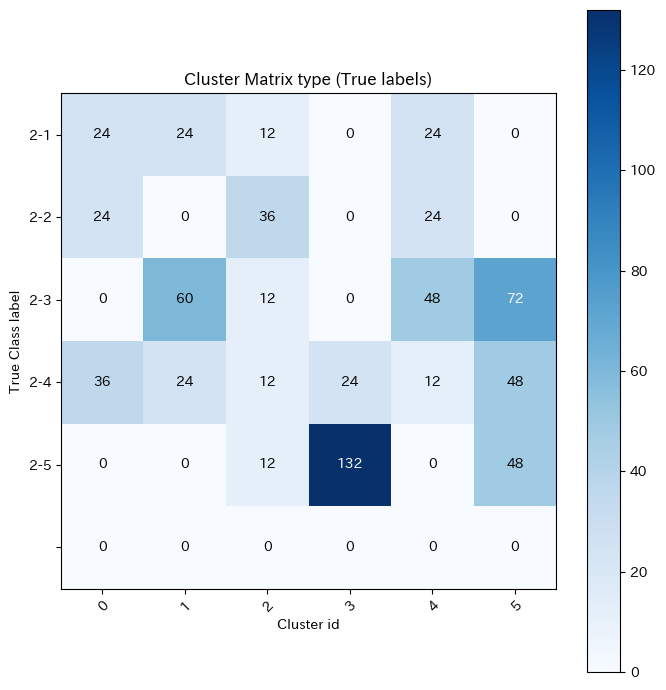

In [22]:
true_labels = [label_dict[cat_re.match(item.numpy().decode())[1]] for item in train_list_ds]
true_ids = [categories1.index(cat[0]) for cat in true_labels]

true_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(true_ids, tf.int64))

cluster_matrix = np.zeros((NUM_CLASSES, NUM_CLUSTERS), dtype=np.int32)

for i, cat_id in enumerate(true_label_ds.batch(BATCH_SIZE)):
    for true, kmp in zip(cat_id, km_predictions[i*BATCH_SIZE:(i+1)*BATCH_SIZE]):
      cluster_matrix[true, kmp] += 1

fig = plot_matrix(cluster_matrix, range(NUM_CLUSTERS), categories1, \
                  'Cluster id', 'True Class label','Cluster Matrix type (True labels)')

fig.savefig('cluster_matrix_true.png', dpi=600)
plt.show()

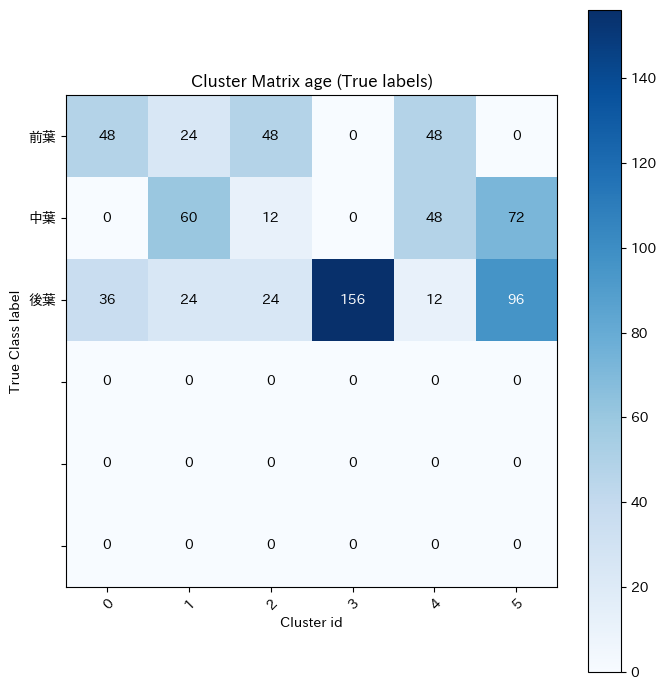

In [23]:

true_ids2 = [categories2.index(cat[1]) for cat in true_labels]
true_label_ds2 = tf.data.Dataset.from_tensor_slices(tf.cast(true_ids2, tf.int64))

cluster_matrix = np.zeros((NUM_CLASSES, NUM_CLUSTERS), dtype=np.int32)

for i, cat_id in enumerate(true_label_ds2.batch(BATCH_SIZE)):
    for true, kmp in zip(cat_id, km_predictions[i*BATCH_SIZE:(i+1)*BATCH_SIZE]):
      cluster_matrix[true, kmp] += 1

fig = plot_matrix(cluster_matrix, range(NUM_CLUSTERS), categories2, \
                  'Cluster id', 'True Class label','Cluster Matrix age (True labels)')

fig.savefig('cluster_matrix_age.png', dpi=600)
plt.show()

## クラスタ可視化

### plot用のラベル

In [24]:
pseudo_dataset = tf.data.experimental.load(DATASET_SAVE_PATH)

cc_re = re.compile(r'.+/.+_(.+?)_[0-9]_[0-9]_[0-9]+_[0-9]+\.npy')
aaa = [ cc_re.match(item.numpy().decode())[1] for item, label in pseudo_dataset]
label_1 = [label_dict[a][0] for a in aaa]
label_2 = [label_dict[a][1] for a in aaa]

### PCAを標準化

In [25]:
tsne = TSNE(n_components=2, random_state=0, init='pca')
projections = tsne.fit_transform(features_std)

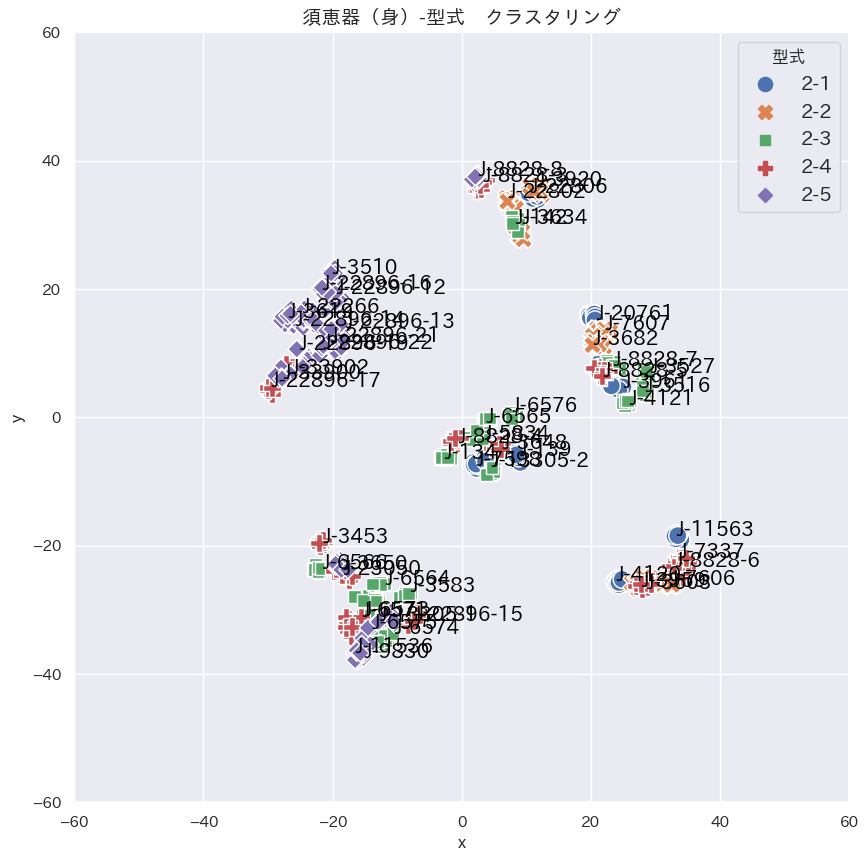

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
sns.set(font='IPAexGothic')
 

x = projections[:,0]
y = projections[:,1]
symbol=label_1
df = pd.DataFrame({'x':x,'y':y, '型式':symbol})

df_s = df.sort_values('型式')
ax = plt.figure(figsize=(10,10))

ax = sns.scatterplot(x='x', y='y', hue='型式', style='型式',data=df_s, s=170)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
#ax.set_xlim(0,20)
#ax.set_ylim(20,40)

for line in range(0,df.shape[0]):
  if (line % 12 != 0):
    continue
  ax.text(df.x[line]+0.2, df.y[line], aaa[line], horizontalalignment='left', size='large',#'medium', \
          color='black', weight='semibold')

ax.legend(title='型式',markerscale=1.7,fontsize=14)
if MI_FUTA == 'futa':
  plt.title("須恵器（蓋）-型式　クラスタリング", fontsize=14)
elif MI_FUTA == 'mi':
  plt.title("須恵器（身）-型式　クラスタリング", fontsize=14)

plt.savefig(MI_FUTA+"_type.png", dpi=600)
plt.show()

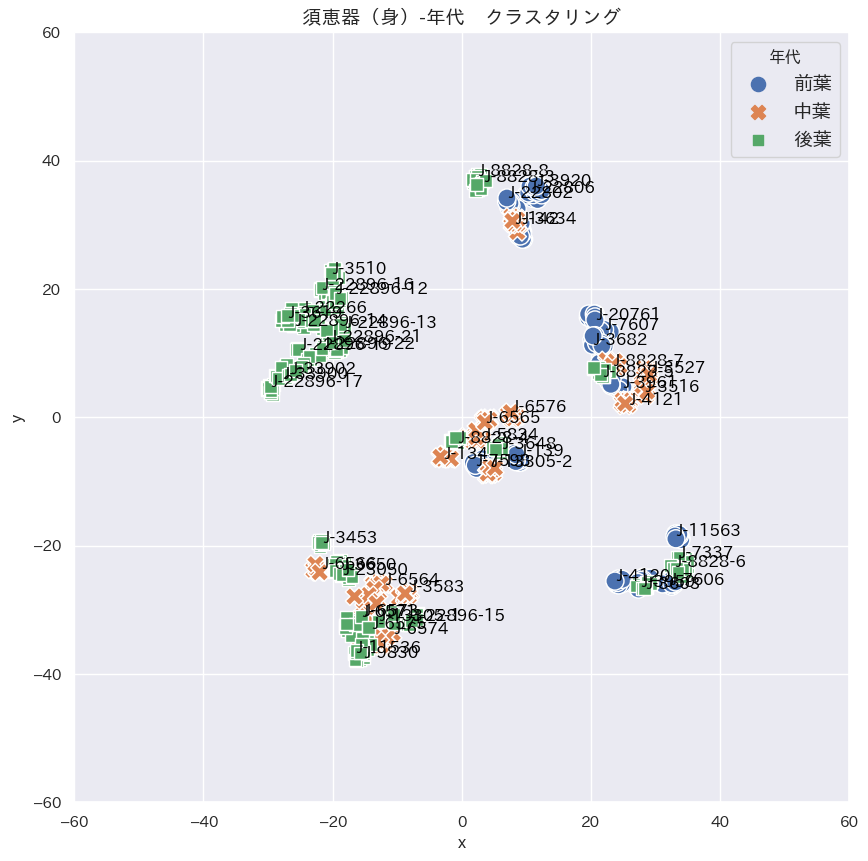

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
sns.set(font='IPAexGothic')
 

x = projections[:,0]
y = projections[:,1]
color = label_2
symbol = label_2
df = pd.DataFrame({'x':x,'y':y, 'name':aaa, '時代r':color,'init':symbol})
df['時代'] = df['時代r'].apply(lambda x: ["前葉","中葉","後葉"].index(x) if x in ["前葉","中葉","後葉"] else -1)


df_s = df.sort_values('時代')
ax = plt.figure(figsize=(10,10))

ax = sns.scatterplot(x='x', y='y', hue='時代r', style='時代r',data=df_s, s=170)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
#ax.set_xlim(0,20)
#ax.set_ylim(20,40)

for line in range(0,df_s.shape[0]):
  if (line % 12 != 0):
    continue
  plt.text(df_s.loc[line,'x']+0.2, df_s.loc[line,'y'], df_s.loc[line,'name'],\
           horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.legend(title='年代',markerscale=1.7,fontsize=14)
if MI_FUTA == 'futa':
  plt.title("須恵器（蓋）-年代　クラスタリング", fontsize=14)
elif MI_FUTA == 'mi':
  plt.title("須恵器（身）-年代　クラスタリング", fontsize=14)
plt.savefig(MI_FUTA+"_age.png", dpi=600)
plt.show()

In [ ]:
#tsne = TSNE(n_components=2, random_state=0)
#projections1 = tsne.fit_transform(features_std1)

x = projections[:,0]
y = projections[:,1]
color = label_1
symbol = np.array(train_ids)
df = pd.DataFrame({'x':x,'y':y, 'name':aaa,'型式':color, 'init':symbol})

df_s = df.sort_values(by=['型式','init'], ascending=[True,True])


fig = px.scatter(
    df_s.loc[:,["x","y"]].values, x=0, y=1,
    color=df_s.loc[:,"型式"].values,
    symbol=df_s.loc[:,"init"].values,
    labels={'color': 'Categories'},
    title='PCA後標準化-型式',
    text=df_s.loc[:,"name"],
    width=1000, height=1000,
    size_max=10,
    size=np.full(len(label_2), 10),
)


fig.update_layout(
    legend_title="   型式",
    font=dict(
        family="Courier New, monospace",
        size=14,
    )
)
fig.show()
fig.write_html("pca_std_type.html")

In [ ]:

#tsne = TSNE(n_components=2, random_state=0)
#projections2 = tsne.fit_transform(features_std2)

x = projections[:,0]
y = projections[:,1]
color = label_2
symbol = np.array(train_ids)
df = pd.DataFrame({'x':x,'y':y, 'name':aaa,'時代r':color, 'init':symbol})


df['時代'] = df['時代r'].apply(lambda x: ["前葉","中葉","後葉"].index(x) if x in ["前葉","中葉","後葉"] else -1)
df_s = df.sort_values(by=['時代','init'], ascending=[True,True])


fig = px.scatter(
    df_s.loc[:,["x","y"]].values, x=0, y=1,
    color=df_s.loc[:,"時代r"].values,
    symbol=df_s.loc[:,"init"].values,
    labels={'color': 'Categories'},
    title='PCA後標準化-年代',
    text=df_s.loc[:,"name"],
    width=1000, height=1000,
    size_max=10,
    size=np.full(len(label_2), 10),
)


fig.update_layout(
    legend_title="   年代",#，初期ラベル",
    font=dict(
        family="Courier New, monospace",
        size=14,
    )
)
fig.show()
fig.write_html("pca_std_age.html")

### エルボー法の適用

In [28]:
inertias1 = []
for k in range(2,16):
    kmc = KMeans(n_clusters=k, init='k-means++', n_init=16, max_iter=300,
                           tol=0.0001, verbose=0, random_state=None, copy_x=True)

    km_predictions1_e = kmc.fit_predict(features_std)
    inertias1.append(kmc.inertia_)

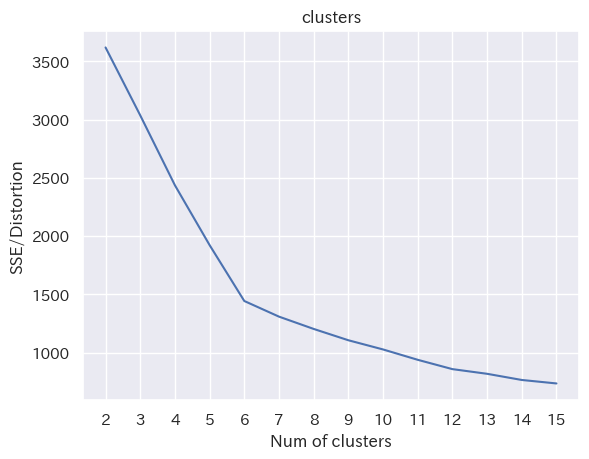

In [29]:
plt.plot(range(2,16), inertias1, '-')
plt.xticks(range(2,16))
plt.title("clusters")
plt.xlabel('Num of clusters')
plt.ylabel('SSE/Distortion')
plt.savefig('elbow_chart.png', dpi=600)
plt.show()

### グラフなどを保存する

In [ ]:
!mkdir {DATASAVE_DIR}
!cp -r *.png *.npy *.html *.hdf5 *.csv {DATASET_SAVE_PATH} {DATASET_SAVE_PATH}-inital {DATASAVE_DIR}
!zip -r {DATASAVE_DIR}.zip {DATASAVE_DIR}

  adding: mi_20230223-128-selu-noise-alpha-random2-IV3_deg30_cls6_ep60/ (stored 0%)
  adding: mi_20230223-128-selu-noise-alpha-random2-IV3_deg30_cls6_ep60/mi_age.png (deflated 6%)
  adding: mi_20230223-128-selu-noise-alpha-random2-IV3_deg30_cls6_ep60/features_std.npy (deflated 8%)
  adding: mi_20230223-128-selu-noise-alpha-random2-IV3_deg30_cls6_ep60/mi_type.png (deflated 6%)
  adding: mi_20230223-128-selu-noise-alpha-random2-IV3_deg30_cls6_ep60/km_predictions.npy (deflated 94%)
  adding: mi_20230223-128-selu-noise-alpha-random2-IV3_deg30_cls6_ep60/pseudo_dataset_20230223-128-selu-noise-alpha-random2-IV3_mi_cls6_ep60.csv (deflated 84%)
  adding: mi_20230223-128-selu-noise-alpha-random2-IV3_deg30_cls6_ep60/pca_std_age.html (deflated 70%)
  adding: mi_20230223-128-selu-noise-alpha-random2-IV3_deg30_cls6_ep60/pca_std_type.html (deflated 70%)
  adding: mi_20230223-128-selu-noise-alpha-random2-IV3_deg30_cls6_ep60/feature_extractor_20230223-128-selu-noise-alpha-random2-IV3_mi_cls6_ep60.hdf5 